In [227]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pylab as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
import seaborn as sns

As we can see in the report conditions and icon were high correlated so we are going to only use one of them, in this case conditions

In [245]:
df=pd.read_csv("final.csv",parse_dates=["Date"])
numerical=["hour","temp","feelslike","dew","humidity","cloudcover","visibility"]
categorical=["WorkDay","Holiday","conditions"]
#dict_to_convert=dict((i,"category") if i in categorical else (i,"float") for i in (numerical+categorical))
#df_use=df[numerical+categorical].astype(dict_to_convert)
limit=-216

df_train_full, df_test=df.iloc[:limit].reset_index(drop=True),df.iloc[limit:].reset_index(drop=True)
X_train=df_train_full[categorical+numerical]
y_train=df_train_full["count"].values
X_test=df_test[categorical+numerical]
y_test=df_test["count"].values
preprocessor_x = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='if_binary',handle_unknown="ignore"), make_column_selector(dtype_include=['object', 'category','bool'])),
        ('num',StandardScaler(),make_column_selector(dtype_exclude=['object', 'category','bool']))])
#X_train=preprocessor_x.fit_transform(X_train)

# Testing linear model regressions 

In [147]:
from sklearn.linear_model import LinearRegression

We scale the target value

In [166]:
regr=TransformedTargetRegressor(regressor=LinearRegression(),transformer=StandardScaler())
pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])

In [171]:

pipe.fit(X_train,y_train)
print(pipe.score(X_test,y_test),pipe.score(X_train,y_train))

0.3455444958321825 0.24818586849480984


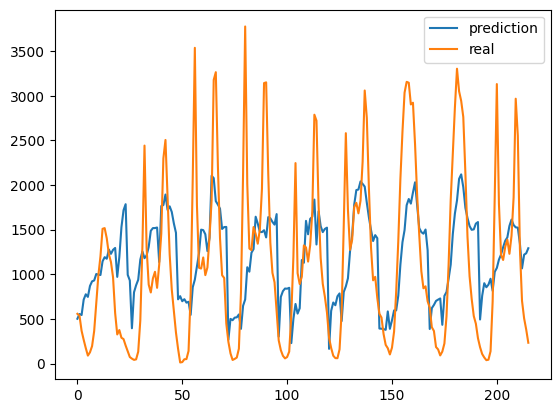

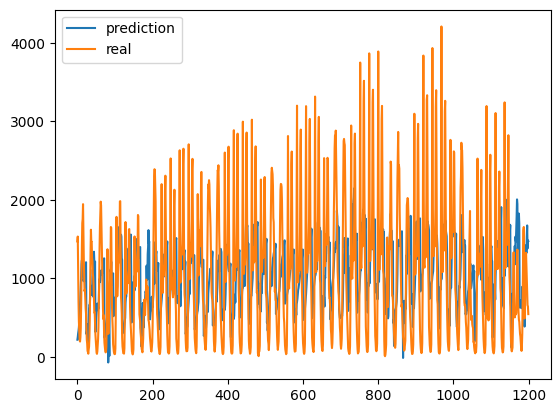

In [172]:
plt.plot(pipe.predict(X_test),label="prediction")
plt.plot(y_test,label="real")
plt.legend()
plt.show()
plt.plot(pipe.predict(X_train),label="prediction")
plt.plot(y_train,label="real")
plt.legend()
plt.show()

# Testing Elastic Net

In [180]:
from sklearn.linear_model import ElasticNetCV

In [181]:
regr =TransformedTargetRegressor(regressor=ElasticNetCV(cv=10),transformer=StandardScaler())
pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])

In [182]:
pipe.fit(X_train,y_train)
print(pipe.score(X_test,y_test),pipe.score(X_train,y_train))

0.32060953894427324 0.24729758721817185


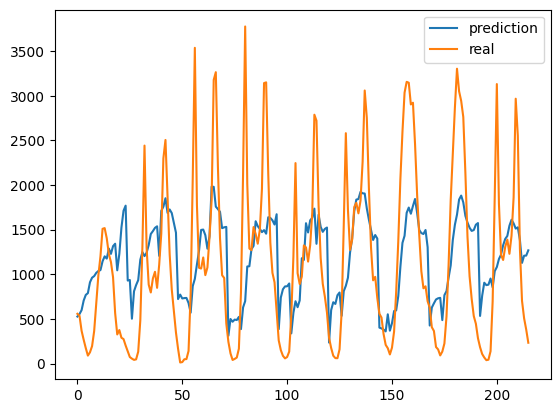

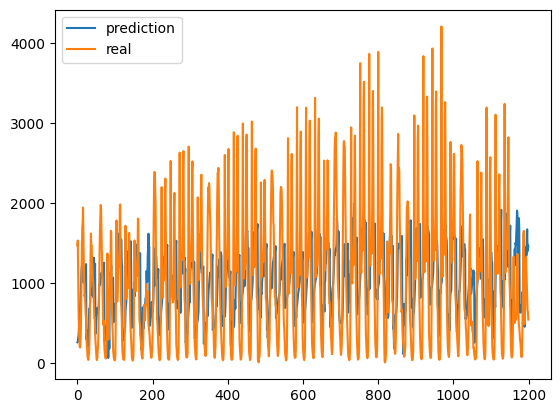

In [183]:
plt.plot(pipe.predict(X_test),label="prediction")
plt.plot(y_test,label="real")
plt.legend()
plt.show()
plt.plot(pipe.predict(X_train),label="prediction")
plt.plot(y_train,label="real")
plt.legend()
plt.show()

# Testing a bayes regressor

In [190]:
from sklearn.linear_model import ARDRegression


0.32672575681834704 0.24644700961440913


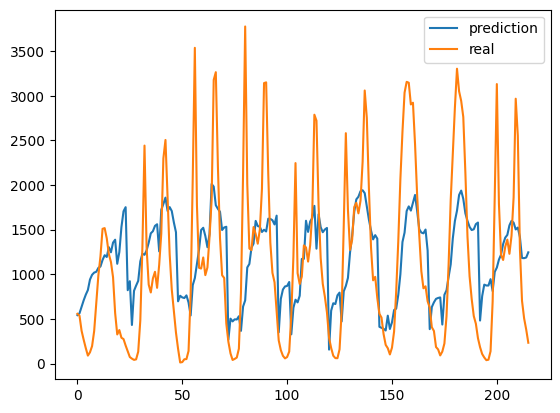

In [208]:
regr =TransformedTargetRegressor(regressor=ARDRegression(),transformer=StandardScaler())
#regr = ARDRegression()
pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])
pipe.fit(X_train,y_train)
print(pipe.score(X_test,y_test),pipe.score(X_train,y_train))
plt.plot(pipe.predict(X_test),label="prediction")
plt.plot(y_test,label="real")
plt.legend()
plt.show()
# plt.plot(pipe.predict(X_train),label="prediction")
# plt.plot(y_train,label="real")
# plt.legend()
# plt.show()

# Lets test a GLM

0.2959943086855259 0.22178810494402057


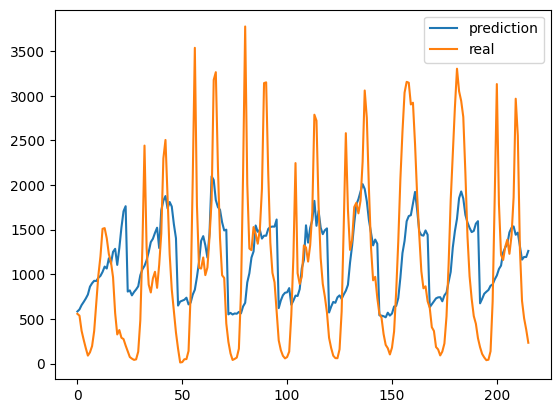

In [225]:
from sklearn.linear_model import TweedieRegressor
#regr =TransformedTargetRegressor(regressor=TweedieRegressor(power=2,link="log"),transformer=StandardScaler())
regr =TweedieRegressor(power=1.2,alpha=50,max_iter=500)
pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])
pipe.fit(X_train,y_train)
print(pipe.score(X_test,y_test),pipe.score(X_train,y_train))
plt.plot(pipe.predict(X_test),label="prediction")
plt.plot(y_test,label="real")
plt.legend()
plt.show()

Since these models have different parameters we are going to perform a grid search

In [232]:
np.linspace(0.5,5,20)

array([0.5       , 0.73684211, 0.97368421, 1.21052632, 1.44736842,
       1.68421053, 1.92105263, 2.15789474, 2.39473684, 2.63157895,
       2.86842105, 3.10526316, 3.34210526, 3.57894737, 3.81578947,
       4.05263158, 4.28947368, 4.52631579, 4.76315789, 5.        ])

In [255]:
regr =TweedieRegressor(max_iter=500)
pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("regression",regr)])
param_grid = {'regression__power': [0,1,2,3]+list(np.linspace(1,2,10)),
             'regression__alpha': np.linspace(0.5,5,20)}
grid_search = GridSearchCV(pipe,param_grid=param_grid,refit=True)

In [256]:
grid_search

GridSearchCV(estimator=Pipeline(steps=[('prepare_X',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc41da99d0>),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc41da91c0>)])),
                                       ('regression...
       1.68421053, 1.92105263, 2.15789474, 2.39473684, 2.63157895,
       2.86842105, 3.10526316, 3.34210526, 3.57894737, 3.81578947,
       4.05263158, 4.28947368, 4.52631579, 4.76315789, 5.        ]),
                         'regression__power': [0, 1, 2, 3, 1.0,
                                               1.1111111111111112,
                                               1.2222222222222223,
                                               1.3333333333333333,
                                               1.4444444444444444,
                                               1.5555555555555556,
                                               1.6666666666666665,
                                               1.7777777777777777,
                                               1.8888888888888888, 2.0]})

In [257]:
grid_search.fit(X_train,y_train)

/Users/jamontana/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jamontana/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jamontana/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jamontana/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Use

GridSearchCV(estimator=Pipeline(steps=[('prepare_X',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc41da99d0>),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc41da91c0>)])),
                                       ('regression...
       1.68421053, 1.92105263, 2.15789474, 2.39473684, 2.63157895,
       2.86842105, 3.10526316, 3.34210526, 3.57894737, 3.81578947,
       4.05263158, 4.28947368, 4.52631579, 4.76315789, 5.        ]),
                         'regression__power': [0, 1, 2, 3, 1.0,
                                               1.1111111111111112,
                                               1.2222222222222223,
                                               1.3333333333333333,
                                               1.4444444444444444,
                                               1.5555555555555556,
                                               1.6666666666666665,
                                               1.7777777777777777,
                                               1.8888888888888888, 2.0]})

In [258]:
result=pd.DataFrame(grid_search.cv_results_)

In [259]:
result.sort_values(by=["mean_test_score"],ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression__alpha,param_regression__power,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.016744,0.003719,0.003136,0.000835,0.5,1.666667,"{'regression__alpha': 0.5, 'regression__power'...",0.064014,0.090016,0.169920,0.207251,0.201539,0.146548,0.058759,1
9,0.021848,0.002846,0.002877,0.000489,0.5,1.555556,"{'regression__alpha': 0.5, 'regression__power'...",0.053237,0.089378,0.169429,0.215134,0.203033,0.146042,0.063863,2
23,0.015590,0.002372,0.002538,0.000528,0.736842,1.555556,"{'regression__alpha': 0.7368421052631579, 'reg...",0.055534,0.085722,0.170655,0.212949,0.202146,0.145401,0.063337,3
24,0.012392,0.002634,0.002556,0.000485,0.736842,1.666667,"{'regression__alpha': 0.7368421052631579, 'reg...",0.065631,0.085863,0.171177,0.203313,0.199958,0.145189,0.058142,4
11,0.012424,0.000640,0.002597,0.000468,0.5,1.777778,"{'regression__alpha': 0.5, 'regression__power'...",0.072775,0.089363,0.169659,0.195018,0.197638,0.144891,0.053278,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.005401,0.000318,0.002450,0.000244,4.052632,3,"{'regression__alpha': 4.052631578947368, 'regr...",-0.035766,-0.000430,-0.005145,-0.010900,-0.001590,-0.010766,0.013020,276
227,0.004957,0.000353,0.002293,0.000509,4.289474,3,"{'regression__alpha': 4.289473684210526, 'regr...",-0.035767,-0.000432,-0.005148,-0.010903,-0.001592,-0.010768,0.013020,277
241,0.004927,0.000419,0.002060,0.000093,4.526316,3,"{'regression__alpha': 4.526315789473684, 'regr...",-0.035768,-0.000433,-0.005150,-0.010905,-0.001594,-0.010770,0.013020,278
255,0.005232,0.000433,0.002590,0.000654,4.763158,3,"{'regression__alpha': 4.763157894736842, 'regr...",-0.035769,-0.000435,-0.005151,-0.010907,-0.001596,-0.010772,0.013019,279


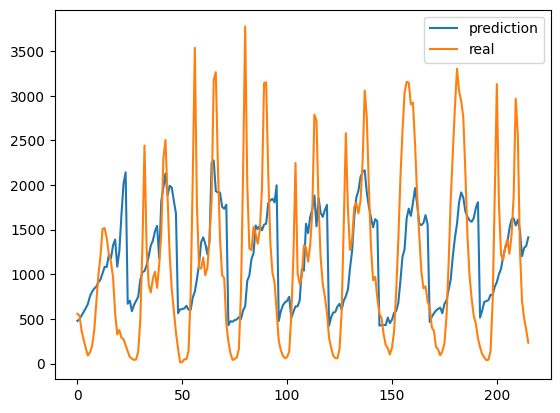

In [260]:
plt.plot(grid_search.predict(X_test),label="prediction")
plt.plot(y_test,label="real")
plt.legend()
plt.show()

In [261]:
grid_search.score(X_test,y_test)

0.2720833355007579

One of the reasons this might not work well is because we are having deviations from Normality, so lets try something a bit more robust

# Now we are going to test with a Random Forest Tree

In [262]:
from sklearn.ensemble import RandomForestRegressor

0.8891681766231151 0.9856766163492068


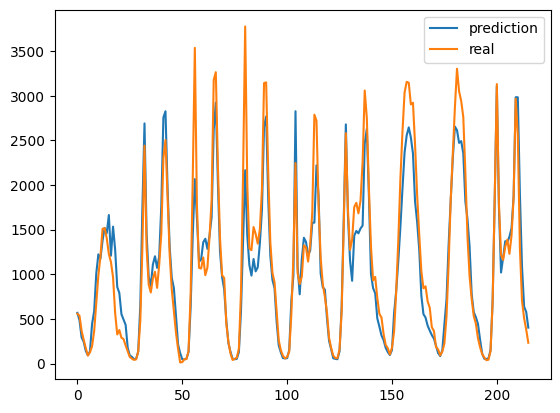

In [315]:
#regr =TransformedTargetRegressor(regressor=RandomForestRegressor(oob_score=True),transformer=StandardScaler())
regr =RandomForestRegressor(oob_score=True,criterion="poisson")
pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])
pipe.fit(X_train,y_train)
print(pipe.score(X_test,y_test),pipe.score(X_train,y_train))
plt.plot(pipe.predict(X_test),label="prediction")
plt.plot(y_test,label="real")
plt.legend()
plt.show()

In [314]:
pipe["scaled_regression"].oob_score_

0.8911746692365463

Since this performs way better we are going to perform a grid search for this specific regressor


















































In [283]:
pipe

Pipeline(steps=[('prepare_X',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc41da99d0>),
                                                 ('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc41da91c0>)])),
                ('scaled_regression',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(oob_score=True),
                                            transformer=StandardScaler()))])

In [308]:
oob_score=pipe["scaled_regression"].regressor_.oob_score_

In [280]:
reg=pipe.get_params()['scaled_regression__regressor']

In [282]:
reg.base_estimator_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [309]:

param_grid = ParameterGrid(
                {'n_estimators': [50,70,90,130,150],
                 'max_features': [None, 'sqrt', 'log2'],
                 'min_samples_leaf': [1, 5, 10, 15, 20, 500, 100, 200],
                 'max_depth'   : [None, 5, 15, 21, 31],
                 'criterion'   : ["squared_error", "absolute_error"]
                }
            )
resultados = {'params': [], 'oob_accuracy': [],'test_accuracy':[]}

for params in param_grid:
    
    regr = TransformedTargetRegressor(regressor=RandomForestRegressor(oob_score= True,random_state = 11,** params),transformer=StandardScaler())
    pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])
    pipe.fit(X_train,y_train)
    
    resultados['params'].append(params)
    
    resultados['oob_accuracy'].append(pipe["scaled_regression"].regressor_.oob_score_)
    resultados['test_accuracy'].append(pipe.score(X_test,y_test))
    print(f"Modelo: {params} \u2713")

#pipe.fit(X_train,y_train)

Modelo: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 70} ✓
Modelo: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 90} ✓
Modelo: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 130} ✓
Modelo: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 70} ✓
Modelo: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 90} 

ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

In [316]:
param_grid = ParameterGrid(
                {'n_estimators': [50,70,90,130,150],
                 'max_features': [None, 'sqrt', 'log2'],
                 'min_samples_leaf': [1, 5, 10, 15, 20, 500, 100, 200],
                 'max_depth'   : [None, 5, 15, 21, 31],
                 'criterion'   : ["poisson"]
                }
            )
#resultados = {'params': [], 'oob_accuracy': [],'test_accuracy':[]}

for params in param_grid:
    
    regr = RandomForestRegressor(oob_score= True,random_state = 11,** params)
    pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])
    pipe.fit(X_train,y_train)
    
    resultados['params'].append(params)
    
    resultados['oob_accuracy'].append(pipe["scaled_regression"].oob_score_)
    resultados['test_accuracy'].append(pipe.score(X_test,y_test))
    print(f"Modelo: {params} \u2713")

Modelo: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50} ✓
Modelo: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 70} ✓
Modelo: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 90} ✓
Modelo: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 130} ✓
Modelo: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 70} ✓
Modelo: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 90} ✓
Modelo: {'criterion': 'poisson', 'max_depth': 

In [319]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values(['test_accuracy'], ascending=False)
resultados = resultados.drop(columns = 'params')


In [321]:
resultados.head(5)

,oob_accuracy,test_accuracy,criterion,max_depth,max_features,min_samples_leaf,n_estimators,criterion,max_depth,max_features,min_samples_leaf,n_estimators
1440,0.891006,0.899277,poisson,15.0,None,1,50,poisson,15.0,None,1,50
1448,0.874236,0.895894,poisson,15.0,None,5,130,poisson,15.0,None,5,130
1446,0.870060,0.895873,poisson,15.0,None,5,70,poisson,15.0,None,5,70
1200,0.892712,0.895872,poisson,NaN,None,1,50,poisson,NaN,None,1,50
1680,0.892712,0.895872,poisson,31.0,None,1,50,poisson,31.0,None,1,50


0.887179267157909 0.9839923476428725


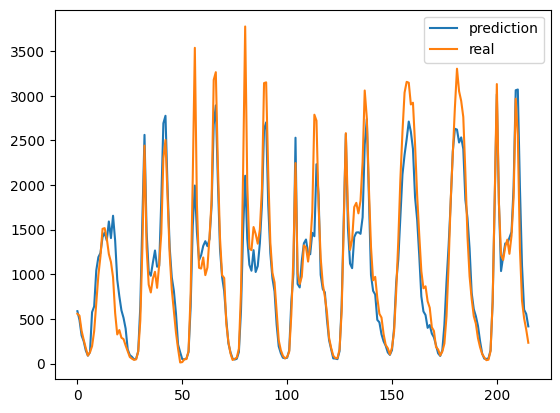

In [323]:
regr =RandomForestRegressor(oob_score=True,criterion="poisson",max_depth=15,max_features=None,min_samples_leaf=1,n_estimators=50)
pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])
pipe.fit(X_train,y_train)
print(pipe.score(X_test,y_test),pipe.score(X_train,y_train))
plt.plot(pipe.predict(X_test),label="prediction")
plt.plot(y_test,label="real")
plt.legend()
plt.show()

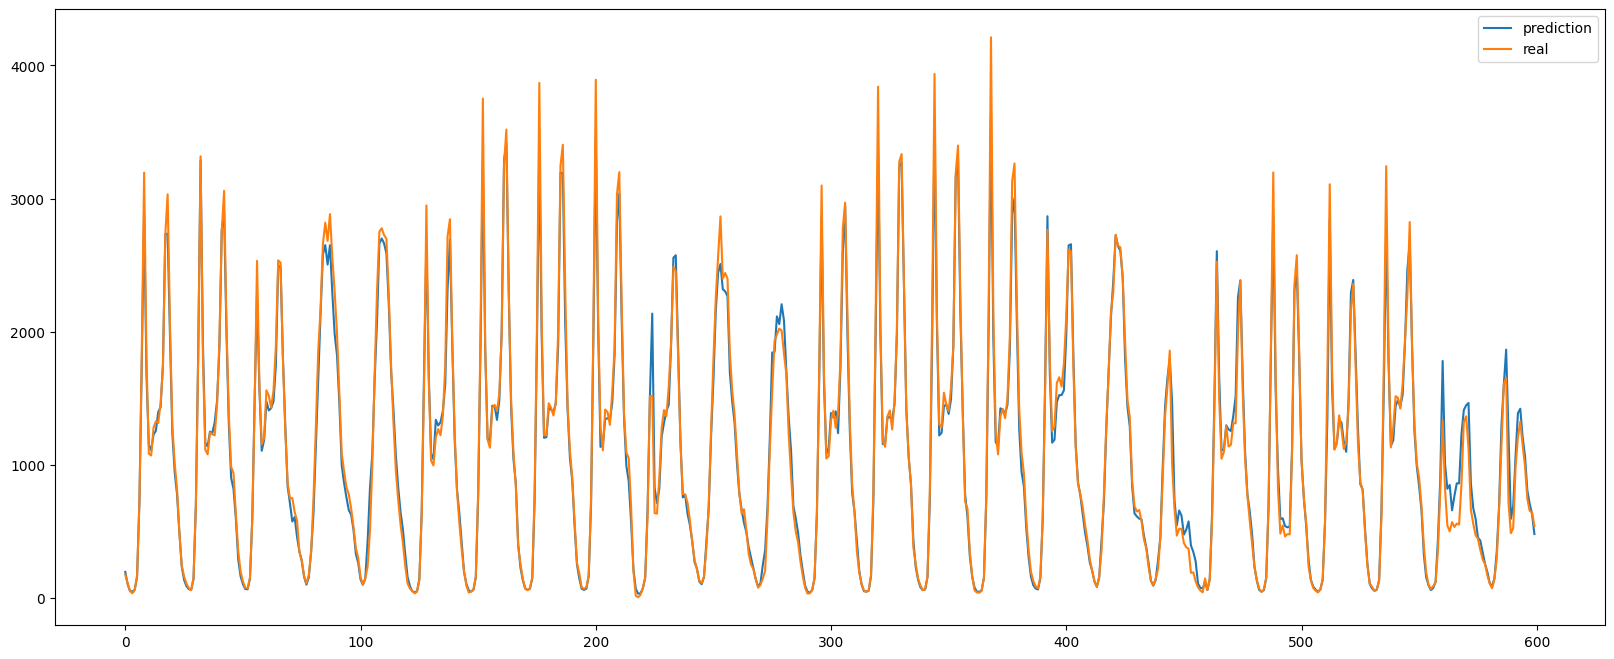

In [328]:
plt.figure(figsize=(20,8))
plt.plot(pipe.predict(X_train[600:]),label="prediction")
plt.plot(y_train[600:],label="real")
plt.legend()
plt.show()

In [329]:
import bentoml

In [330]:
bentoml.sklearn.save_model(
    "demand_prediction_service",
    pipe,
    signatures={
        'predict': {
            'batchable': True,
            'batch_dim': 0
        }
    })

Model(tag="demand_prediction_service:tvopn7c3t6pohqr2", path="/Users/jamontana/bentoml/models/demand_prediction_service/tvopn7c3t6pohqr2/")

In [332]:
X_test.to_csv("data_test.csv",index=False)

In [335]:
pd.Series(y_test,name="target").to_csv("y_test.csv",index=False)

In [337]:
X_train.to_csv("data_train.csv",index=False)

In [339]:
pd.Series(y_train,name="target").to_csv("y_train.csv",index=False)